# Machine Learning with Football Fantasy League Data

## 1. Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import csv

## 2. Get Stats From Files

### 2a. Define functions to get and check data in .csv files

In [2]:
def getGameWeek(file):
    for year in range(16, 23):
        if (file.find(f'FPL{year}') != -1):
            return int(file.replace(f'FPL{year}-GW', '').replace('.csv', ''))

def getGameYear(file):
    for week in range(0, 52):
        if (file.find(f'-GW{week}.csv') != -1):
            return int(file.replace(f'-GW{week}.csv', '').replace('FPL', ''))

def checkCSV(filepath):
    if (len(filepath) == 0):
        return False
    elif (os.path.exists(filepath)):
        with open(filepath) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            line_count = 0
            for row in csv_reader:
                if (line_count == 1):
                    return True
                line_count += 1
            return False
    else:
        return False

### 2b. Create an array of training files

In [3]:
training_folder = './/Data//Train//'

training_files = [{'game_year': getGameYear(file), 'game_week': getGameWeek(file), 'filepath': f'{training_folder}{file}'} for file in os.listdir(training_folder)]

df_training_files = pd.DataFrame(training_files)

df_training_files = df_training_files.sort_values(by=['game_year', 'game_week'])

df_training_files = df_training_files.dropna()

df_training_files = df_training_files.reset_index()

df_training_files

,index,game_year,game_week,filepath
0,54,16.0,5.0,.//Data//Train//FPL16-GW5.csv
1,74,16.0,6.0,.//Data//Train//FPL16-GW6.csv
2,63,16.0,7.0,.//Data//Train//FPL16-GW7.csv
3,172,16.0,8.0,.//Data//Train//FPL16-GW8.csv
4,177,16.0,9.0,.//Data//Train//FPL16-GW9.csv
...,...,...,...,...
212,15,21.0,33.0,.//Data//Train//FPL21-GW33.csv
213,38,21.0,34.0,.//Data//Train//FPL21-GW34.csv
214,34,21.0,35.0,.//Data//Train//FPL21-GW35.csv
215,22,21.0,36.0,.//Data//Train//FPL21-GW36.csv


### 2c. Combine the data from all the files

In [4]:
# Create an empty dataframe in which to add each file's data to
df_training = pd.DataFrame([])

# Iterate through the files dataframe
for index, row in df_training_files.iterrows():
    """
    Iterate through each file in the training folder
    Calculate the current week's points by subtracting the previous week's points from this week's
    Merge the current week's points with the previous week's data if it is not the first week of that year
    Merging is done on the player's full name
    Append the merged dataframe to the dataframe containing every week
    
    """
    
    # Get current week's info
    game_year = row['game_year']
    game_week = row['game_week']
    filepath = row['filepath']
    
    # Get previous week's info
    previous_game_week = game_week - 1
    previous_file_series = df_training_files.loc[(df_training_files['game_year'] == game_year)
                                      & (df_training_files['game_week'] == previous_game_week)]

    first_game_week = df_training_files.loc[df_training_files['game_year'] == game_year]['game_week'].min()
    
    # Check if both files are good
    if (checkCSV(filepath) & (previous_file_series.empty != True)):
        previous_filepath = previous_file_series['filepath'].tolist()[0]
        
        if (checkCSV(previous_filepath)):
            # Create current week's dataframe, remove NA names and build the FullName column on which to join
            df_current = pd.read_csv(filepath, on_bad_lines='warn')
            df_current = df_current[df_current['FirstName'].notna()]
            df_current['FullName'] = df_current['FirstName'].astype(str) + ' ' + df_current['Surname'].astype(str)
            df_current['FullName'] = df_current['FullName'].apply(lambda x: x.strip())

            # Create previous week's dataframe
            df_previous = pd.read_csv(previous_filepath, on_bad_lines='warn')
            df_previous = df_previous[df_previous['FirstName'].notna()]
            df_previous = df_previous.add_prefix('previous_')
            df_previous['FullName'] = df_previous['previous_FirstName'].astype(str) + ' ' + df_previous['previous_Surname'].astype(str)
            df_previous['FullName'] = df_previous['FullName'].apply(lambda x: x.strip())

            # Merge the current and previous week's dataframes on FullName
            df_combined = df_current.merge(df_previous, on='FullName')

            # Calculate the points each player got this week
            df_combined['PointsThisRound'] = df_combined['TotalPoints'].astype(int) - df_combined['previous_TotalPoints'].astype(int)

            # Append the dataframe to the complete dataframe
            df_training = pd.concat([df_training, df_combined], sort=False)
    
df_training = df_training.reset_index()
df_training

b'Skipping line 63: expected 76 fields, saw 95\n'
b'Skipping line 63: expected 76 fields, saw 95\n'


,index,FirstName,Surname,PositionsList,Team,Cost,PointsLastRound,TotalPoints,AveragePoints,AveragePointsPerDollar,...,GW4Forecast,GW5Forecast,GW6Forecast,ICTIndex,previous_GW1Forecast,previous_GW2Forecast,previous_GW3Forecast,previous_GW4Forecast,previous_GW5Forecast,previous_ICTIndex
0,0,Almen,Abdi,MID,WAT,5000000,0,0,0.000000,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Charlie,Adam,MID,STK,4700000,0,0,0.000000,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Albert,Adomah,MID,MID,5400000,0,3,1.500000,2.777778e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Ibrahim,Afellay,MID,STK,5400000,0,0,0.000000,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Benik,Afobe,FWD,BOU,5700000,1,2,0.111111,1.949318e-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113047,642,Christoph,Zimmermann,DEF,NOR,4400000,0,0,0.000000,0.000000e+00,...,NaN,NaN,NaN,3.7,NaN,NaN,NaN,NaN,NaN,2.8
113048,643,Oleksandr,Zinchenko,DEF,MCI,5300000,4,59,1.594595,3.008669e-07,...,NaN,NaN,NaN,65.4,NaN,NaN,NaN,NaN,NaN,59.5
113049,644,Philip,Zinckernagel,MID,WAT,5500000,0,0,0.000000,0.000000e+00,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0
113050,645,Hakim,Ziyech,MID,CHE,7300000,2,79,2.135135,2.924843e-07,...,NaN,NaN,NaN,132.6,NaN,NaN,NaN,NaN,NaN,115.2


## 3. Prepare the Model

### 3a. Define the columns used in training the model

In [5]:
training_columns = [column for column in df_training.columns if ((column.find('previous_') >= 0 or column == 'PointsLastRound') and column.find('GW') == -1 and df_training[column].dtypes != 'object')]
training_columns

['PointsLastRound',
 'previous_Cost',
 'previous_PointsLastRound',
 'previous_TotalPoints',
 'previous_AveragePoints',
 'previous_AveragePointsPerDollar',
 'previous_GoalsConceded',
 'previous_GoalsConcededPoints',
 'previous_Saves',
 'previous_SavesPoints',
 'previous_GoalsScored',
 'previous_GoalsScoredPoints',
 'previous_ValueSeason',
 'previous_TransfersOutRound',
 'previous_PriceRise',
 'previous_PriceFallRound',
 'previous_LastSeasonPoints',
 'previous_PriceFall',
 'previous_ValueForm',
 'previous_PenaltiesMissed',
 'previous_Form',
 'previous_Bonus',
 'previous_FanRating',
 'previous_CleanSheets',
 'previous_CleanSheetPoints',
 'previous_Assists',
 'previous_SelectedByPercent',
 'previous_TransfersIn',
 'previous_OwnGoals',
 'previous_EAIndex',
 'previous_PenaltiesSaved',
 'previous_DreamteamCount',
 'previous_MinutesPlayed',
 'previous_TransfersInRound',
 'previous_PriceRiseRound',
 'previous_RedCards',
 'previous_BPS',
 'previous_ICTIndex']

### 3b. Create the datasets for training the model and the column to predict

In [6]:
X = df_training[training_columns]
y = df_training[['PointsThisRound']]
nan_index_list = X[X.isna().any(axis=1)].index.tolist()
index_list = X.index.tolist()
not_nan_index_list = list(set(index_list) - set(nan_index_list))
X = X.iloc[not_nan_index_list]
y = y.iloc[not_nan_index_list]
X

,PointsLastRound,previous_Cost,previous_PointsLastRound,previous_TotalPoints,previous_AveragePoints,previous_AveragePointsPerDollar,previous_GoalsConceded,previous_GoalsConcededPoints,previous_Saves,previous_SavesPoints,...,previous_OwnGoals,previous_EAIndex,previous_PenaltiesSaved,previous_DreamteamCount,previous_MinutesPlayed,previous_TransfersInRound,previous_PriceRiseRound,previous_RedCards,previous_BPS,previous_ICTIndex
18951,0,4500000,0,0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18952,2,5500000,0,0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18953,0,5000000,0,59,4.267841e-27,8.535682e-34,23.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1491.0,0.0,0.0,0.0,218.0,106.7
18954,0,5000000,0,15,5.425222e-27,1.085044e-33,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,384.0,0.0,0.0,0.0,63.0,14.8
18955,2,6000000,0,88,6.365594e-27,1.060932e-33,24.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1458.0,0.0,0.0,0.0,259.0,130.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113047,0,4400000,0,0,0.000000e+00,0.000000e+00,5.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,102.0,27.0,0.0,0.0,14.0,2.8
113048,4,5300000,1,55,1.527778e+00,2.882600e-07,8.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,1.0,999.0,4680.0,0.0,0.0,260.0,59.5
113049,0,5500000,0,0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113050,2,7300000,0,75,2.083333e+00,2.853881e-07,10.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,1.0,1131.0,551.0,0.0,0.0,256.0,115.2


### 3c. Train, test and fit the model

In [7]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

#Create a Gaussian Classifier
clf = DecisionTreeClassifier(
    criterion='gini', 
    splitter='best', 
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features=None, 
    random_state=None, 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None, 
    ccp_alpha=0.0
)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train, y_train)

DecisionTreeClassifier()

## 4. Analyse the Model Results

### 4a. Check importance of columns on prediction

In [8]:
feature_imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_imp

PointsLastRound                    0.805324
previous_TransfersInRound          0.019736
previous_TransfersOutRound         0.018568
previous_BPS                       0.014303
previous_TransfersIn               0.012751
previous_AveragePoints             0.010201
previous_MinutesPlayed             0.009813
previous_SelectedByPercent         0.009336
previous_ICTIndex                  0.009183
previous_Cost                      0.008355
previous_Form                      0.008334
previous_LastSeasonPoints          0.008127
previous_TotalPoints               0.007396
previous_GoalsConceded             0.007261
previous_ValueSeason               0.006969
previous_PointsLastRound           0.005328
previous_CleanSheets               0.004421
previous_EAIndex                   0.004333
previous_ValueForm                 0.003925
previous_Assists                   0.003918
previous_Bonus                     0.003867
previous_PriceRise                 0.003781
previous_PriceFall              

### 4b. Compare feature importance

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


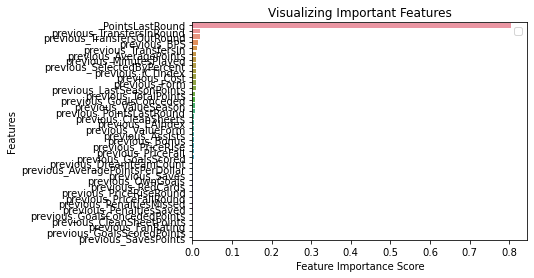

In [9]:
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## 5. Predict Future Data

### 5a. Create an array of testing files

In [10]:
testing_folder = './/Data//Test//'

testing_files = [{'game_year': getGameYear(file), 'game_week': getGameWeek(file), 'filepath': f'{testing_folder}{file}'} for file in os.listdir(testing_folder)]

df_testing_files = pd.DataFrame(testing_files)

df_testing_files = df_testing_files.sort_values(by=['game_year', 'game_week'])

df_testing_files = df_testing_files.dropna()

df_testing_files = df_testing_files.reset_index()

df_testing_files

,index,game_year,game_week,filepath
0,0,22.0,0.0,.//Data//Test//FPL22-GW0.csv


### 5b. Build dataset with which to predict

In [11]:
# Create an empty dataframe in which to add each file's data to
df_predicting = pd.DataFrame([])

# Iterate through the files dataframe
for index, row in df_testing_files.iterrows():
    """
    Iterate through each file in the training folder
    Calculate the current week's points by subtracting the previous week's points from this week's
    Merge the current week's points with the previous week's data if it is not the first week of that year
    Merging is done on the player's full name
    Append the merged dataframe to the dataframe containing every week
    
    """
    
    # Get current week's info
    game_year = row['game_year']
    game_week = row['game_week']
    filepath = row['filepath']
    
    # Get previous week's info
    previous_game_week = game_week - 1
    previous_file_series = df_testing_files.loc[(df_testing_files['game_year'] == game_year)
                                      & (df_testing_files['game_week'] == previous_game_week)]

    first_game_week = df_testing_files.loc[df_testing_files['game_year'] == game_year]['game_week'].min()
    
    if (game_week == first_game_week):
        # Create current week's dataframe, remove NA names and build the FullName column on which to join
        df_current = pd.read_csv(filepath, on_bad_lines='warn')
        df_current = df_current[df_current['FirstName'].notna()]
        df_current = df_current.add_prefix('previous_')
        df_current['FullName'] = df_current['previous_FirstName'].astype(str) + ' ' + df_current['previous_Surname'].astype(str)
        df_current['FullName'] = df_current['FullName'].apply(lambda x: x.strip())
        df_current['PointsLastRound'] = df_current['previous_TotalPoints'].astype(int)
        
        # Append the dataframe to the complete dataframe
        df_predicting = pd.concat([df_predicting, df_current], sort=False)
    
    else:
        # Check if both files are good
        if (checkCSV(filepath) & (previous_file_series.empty != True)):
            previous_filepath = previous_file_series['filepath'].tolist()[0]

            if (checkCSV(previous_filepath)):
                # Create current week's dataframe, remove NA names and build the FullName column on which to join
                df_current = pd.read_csv(filepath, on_bad_lines='warn')
                df_current = df_current[df_current['FirstName'].notna()]
                df_current['FullName'] = df_current['FirstName'].astype(str) + ' ' + df_current['Surname'].astype(str)
                df_current['FullName'] = df_current['FullName'].apply(lambda x: x.strip())

                # Create previous week's dataframe
                df_previous = pd.read_csv(previous_filepath, on_bad_lines='warn')
                df_previous = df_previous[df_previous['FirstName'].notna()]
                df_previous = df_previous.add_prefix('previous_')
                df_previous['FullName'] = df_previous['previous_FirstName'].astype(str) + ' ' + df_previous['previous_Surname'].astype(str)
                df_previous['FullName'] = df_previous['FullName'].apply(lambda x: x.strip())

                # Merge the current and previous week's dataframes on FullName
                df_combined = df_current.merge(df_previous, on='FullName')

                # Calculate the points each player got this week
                df_combined['PointsThisRound'] = df_combined['TotalPoints'].astype(int) - df_combined['previous_TotalPoints'].astype(int)

                # Append the dataframe to the complete dataframe
                df_predicting = pd.concat([df_predicting, df_combined], sort=False)
    
df_predicting = df_predicting.reset_index()
df_predicting

,index,previous_FirstName,previous_Surname,previous_PositionsList,previous_Team,previous_Cost,previous_PointsLastRound,previous_TotalPoints,previous_AveragePoints,previous_AveragePointsPerDollar,...,previous_GW32Forecast,previous_GW33Forecast,previous_GW34Forecast,previous_GW35Forecast,previous_GW36Forecast,previous_GW37Forecast,previous_GW38Forecast,previous_ICTIndex,FullName,PointsLastRound
0,2,Brenden,Aaronson,MID,LEE,5500000,2,2,0.052632,9.569378e-09,...,0.0,0.1,0.0,0.1,0.0,0.1,0.0,2.2,Brenden Aaronson,2
1,4,Che,Adams,FWD,SOU,6500000,0,0,0.000000,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Che Adams,0
2,5,Tyler,Adams,MID,LEE,5000000,1,1,0.026316,5.263158e-09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.1,Tyler Adams,1
3,7,Nayef,Aguerd,DEF,WHU,5000000,0,0,0.000000,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Nayef Aguerd,0
4,8,Rayan,Ait-Nouri,DEF,WOL,4500000,-1,-1,-0.026316,-5.847953e-09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.5,Rayan Ait-Nouri,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,563,Wilfried,Zaha,MID,CRY,7000000,2,2,0.052632,7.518797e-09,...,0.0,0.0,0.1,0.0,0.0,0.0,0.1,7.6,Wilfried Zaha,2
455,564,Jordan,Zemura,DEF,BOU,4500000,6,6,0.157895,3.508772e-08,...,0.2,0.2,0.2,0.2,0.2,0.2,0.2,3.4,Jordan Zemura,6
456,565,Oleksandr,Zinchenko,DEF,ARS,5000000,12,12,0.315789,6.315789e-08,...,0.4,0.4,0.4,0.4,0.4,0.4,0.4,8.5,Oleksandr Zinchenko,12
457,566,Hakim,Ziyech,MID,CHE,6000000,0,0,0.000000,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hakim Ziyech,0


### 5c. Optimise the prediction dataset

In [12]:
X_pred = df_predicting[training_columns]
nan_index_list = X_pred[X_pred.isna().any(axis=1)].index.tolist()
index_list = X_pred.index.tolist()
not_nan_index_list = list(set(index_list) - set(nan_index_list))
X_pred = X_pred.iloc[not_nan_index_list]
X_pred

,PointsLastRound,previous_Cost,previous_PointsLastRound,previous_TotalPoints,previous_AveragePoints,previous_AveragePointsPerDollar,previous_GoalsConceded,previous_GoalsConcededPoints,previous_Saves,previous_SavesPoints,...,previous_OwnGoals,previous_EAIndex,previous_PenaltiesSaved,previous_DreamteamCount,previous_MinutesPlayed,previous_TransfersInRound,previous_PriceRiseRound,previous_RedCards,previous_BPS,previous_ICTIndex
0,2,5500000,2,2,0.052632,9.569378e-09,1,0,0,0,...,0,-1,0,0,84,3856,0,0,4,2.2
1,0,6500000,0,0,0.000000,0.000000e+00,0,0,0,0,...,0,-1,0,0,0,932,0,0,0,0.0
2,1,5000000,1,1,0.026316,5.263158e-09,1,0,0,0,...,0,-1,0,0,90,498,0,0,7,2.1
3,0,5000000,0,0,0.000000,0.000000e+00,0,0,0,0,...,0,-1,0,0,0,84,0,0,0,0.0
4,-1,4500000,-1,-1,-0.026316,-5.847953e-09,2,0,0,0,...,1,-1,0,0,90,1700,0,0,11,6.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,2,7000000,2,2,0.052632,7.518797e-09,2,0,0,0,...,0,-1,0,0,90,4712,0,0,16,7.6
455,6,4500000,6,6,0.157895,3.508772e-08,0,0,0,0,...,0,-1,0,0,90,689,0,0,25,3.4
456,12,5000000,12,12,0.315789,6.315789e-08,0,0,0,0,...,0,-1,0,1,82,165868,0,0,38,8.5
457,0,6000000,0,0,0.000000,0.000000e+00,0,0,0,0,...,0,-1,0,0,0,1015,0,0,0,0.0


### 5d. Predict future results

In [13]:
pred_next_week = clf.predict(X_pred)
pred_next_week = pd.DataFrame(pred_next_week)
pred_next_week

,0
0,0
1,0
2,1
3,0
4,-1
...,...
454,2
455,6
456,12
457,0


### 5e. Display the predicted results

In [14]:
df_prediction_next_week = pred_next_week.set_index(df_predicting.index)
df_prediction_next_week = df_prediction_next_week.rename(columns = {0: f'Predicted{y.columns[0]}'})
df_merged_next_week = df_prediction_next_week.join(df_predicting)
df_merged_next_week = df_merged_next_week.sort_values(by=f'Predicted{y.columns[0]}', ascending=False)
# df_merged_next_week = df_merged_next_week.sort_values(by=f'PointsLastRound', ascending=False)
df_merged_next_week.to_csv(testing_folder+'GW1_Prediction.csv')
df_merged_next_week.head(20)

,PredictedPointsThisRound,index,previous_FirstName,previous_Surname,previous_PositionsList,previous_Team,previous_Cost,previous_PointsLastRound,previous_TotalPoints,previous_AveragePoints,...,previous_GW32Forecast,previous_GW33Forecast,previous_GW34Forecast,previous_GW35Forecast,previous_GW36Forecast,previous_GW37Forecast,previous_GW38Forecast,previous_ICTIndex,FullName,PointsLastRound
227,16,283,Dejan,Kulusevski,MID,TOT,8000000,13,13,3.421053e-01,...,0.4,0.5,0.4,0.5,0.4,0.5,0.4,15.3,Dejan Kulusevski,13
288,16,353,Aleksandar,Mitrovic,FWD,FUL,6500000,13,13,3.421053e-01,...,0.5,0.4,0.5,0.5,0.4,0.5,0.4,15.5,Aleksandar Mitrovic,13
355,12,447,Mohamed,Salah,MID,LIV,13000000,12,12,3.157895e-01,...,0.4,0.4,0.4,0.4,0.4,0.4,0.4,8.5,Mohamed Salah,12
456,12,565,Oleksandr,Zinchenko,DEF,ARS,5000000,12,12,3.157895e-01,...,0.4,0.4,0.4,0.4,0.4,0.4,0.4,8.5,Oleksandr Zinchenko,12
213,12,267,Lloyd,Kelly,DEF,BOU,4500000,12,12,3.157895e-01,...,0.4,0.4,0.4,0.4,0.4,0.4,0.4,6.6,Lloyd Kelly,12
161,11,210,Pascal,Gro?,MID,BHA,5500000,11,11,2.894737e-01,...,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.0,Pascal Gro?,11
400,10,497,Matt,Targett,DEF,NEW,5000000,8,8,2.105263e-01,...,0.3,0.3,0.3,0.3,0.3,0.3,0.3,5.5,Matt Targett,8
111,10,146,Eric,Dier,DEF,TOT,5000000,8,8,2.105263e-01,...,0.3,0.3,0.2,0.3,0.3,0.3,0.3,6.1,Eric Dier,8
356,10,448,William,Saliba,DEF,ARS,4500000,8,8,2.105263e-01,...,0.3,0.3,0.3,0.3,0.3,0.3,0.3,2.2,William Saliba,8
73,9,99,Ben,Chilwell,DEF,CHE,6000000,9,9,6.510266e-28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9,Ben Chilwell,9
